In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Equation: 

# $$ \frac{dx}{dt} = \lambda x$$

# == Setup ==



# Generator (regression):

<img src="generator.png" width="500">

# Discriminator (classification):

<img src="discriminator.png" width="500">

## Analytical Solutionn

In [17]:
L = -1
analytic = lambda t: np.exp(L*t)

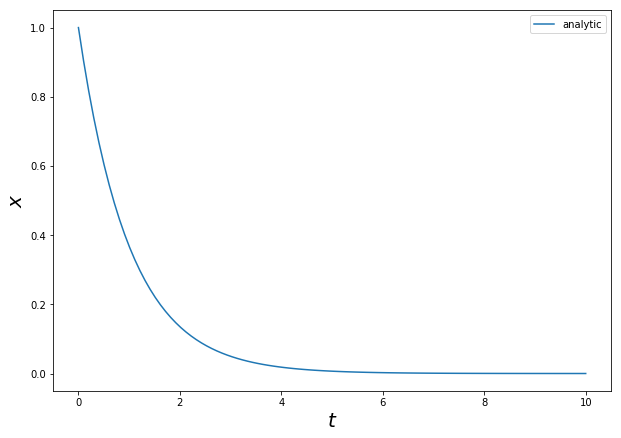

In [30]:
t = np.linspace(0,10,100)
plt.figure(figsize=(10,7))
plt.xlabel('$t$', fontsize=20)
plt.ylabel('$x$', fontsize=20)
plt.plot(t, analytic(t), '-', label='analytic')
plt.legend();

## GAN

In [39]:
import torch
import torch.nn as nn
from torch import tensor, autograd

In [33]:
class Generator(nn.Module):
    def __init__(self, n_hidden=20):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 1) # regression
        )
    
    def forward(self, x):
        output = self.main(x)
        return output

class Discriminator(nn.Module):
    def __init__(self, n_hidden=20):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 1),
            nn.Tanh() # classification
        )
    
    def forward(self, x):
        output = self.main(x)
        return output

In [34]:
G = Generator()
D = Discriminator()

In [37]:
t = tensor(t, dtype=torch.float, requires_grad=True).reshape(-1,1)

In [42]:
real_label = 1
fake_label = 0
criterion = nn.BCELoss()

In [43]:
# setup optimizer
optimizerD = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.9, 0.999))
optimizerG = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.9, 0.999))

In [41]:
for epoch in range(10000):
    
    # predict
    x = G(t)
    
    # compute dx/dt
    dx_dt, = autograd.grad(x, t, grad_outputs=x.data.new(x.shape).fill_(1),
                           retain_graph=True, create_graph=True)
    
    # draw x (real) or dx/dt (fake)
    label = np.random.choice([0, 1], size=t.shape[0])
    d_in = 
    for l in label:
        if l == 0:
            
        
    
    

#     for i, data in enumerate(t):
#         ############################
#         # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
#         ###########################
#         # train with real
#         D.zero_grad()
# #         real_cpu = data[0].to(device)
# #         batch_size = real_cpu.size(0)
#         label = torch.full((batch_size,), real_label, device=device)

#         output = netD(real_cpu)
#         errD_real = criterion(output, label)
#         errD_real.backward()
#         D_x = output.mean().item()

#         # train with fake
#         noise = torch.randn(batch_size, nz, 1, 1, device=device)
#         fake = netG(noise)
#         label.fill_(fake_label)
#         output = netD(fake.detach())
#         errD_fake = criterion(output, label)
#         errD_fake.backward()
#         D_G_z1 = output.mean().item()
#         errD = errD_real + errD_fake
#         optimizerD.step()

#         ############################
#         # (2) Update G network: maximize log(D(G(z)))
#         ###########################
#         netG.zero_grad()
#         label.fill_(real_label)  # fake labels are real for generator cost
#         output = netD(fake)
#         errG = criterion(output, label)
#         errG.backward()
#         D_G_z2 = output.mean().item()
#         optimizerG.step()

#         print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
#               % (epoch, opt.niter, i, len(dataloader),
#                  errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
#         if i % 100 == 0:
#             vutils.save_image(real_cpu,
#                     '%s/real_samples.png' % opt.outf,
#                     normalize=True)
#             fake = netG(fixed_noise)
#             vutils.save_image(fake.detach(),
#                     '%s/fake_samples_epoch_%03d.png' % (opt.outf, epoch),
#                     normalize=True)

#     # do checkpointing
#     torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (opt.outf, epoch))
#     torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (opt.outf, epoch))
